# Worksheet 17

Name:  Qiji Zheng
UID: U03410444

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

### 1. Data Collection
Collect binary feedback from users where each movie is marked as "like" or "dislike." This will form the basis of your dataset, which will likely be sparse since not all users will provide feedback on all movies.

### 2. User and Item Profiles
Create profiles for both users and items (movies):
   - **User Profiles**: A user's profile could be a vector where each element represents a movie and the value indicates whether the user liked it (1), disliked it (0), or has not rated it (often handled as missing data).
   - **Item Profiles**: Similarly, each movie can be represented by a vector showing which users liked or disliked it.

### 3. Choice of Algorithm

#### a. Collaborative Filtering
   - **User-based**: Calculate similarities between users based on their like/dislike patterns. For a target user, find other users with similar tastes and recommend movies liked by those similar users which the target user hasn't seen yet.
   - **Item-based**: Determine similarities between items based on the patterns of likes and dislikes they receive from users. Recommend items that are similar to other items the target user has liked.

#### b. Matrix Factorization Techniques
   - Techniques like Singular Value Decomposition (SVD) can be adapted for binary data. They work by decomposing the user-item matrix into lower-dimensional matrices, capturing latent factors associated with users and items. Predictions can be made by reconstructing the matrix and applying a threshold to decide between like and dislike.

#### c. Logistic Regression
   - Model each user-item interaction as a binary classification problem. Predict the probability of a user liking an item based on other known likes and dislikes.

### 4. Evaluation Metrics
Choose appropriate metrics to evaluate the performance of the recommender system:
   - **Accuracy**: Measure of correct predictions (both likes and dislikes).
   - **Precision and Recall**: Especially useful if you are more interested in one class (e.g., likes).
   - **F1 Score**: Harmonic mean of precision and recall, providing a balance between the two in cases of uneven class distribution.

### 5. Implementation Details
   - Handle new users and new items (cold start problem) by recommending popular or trending items initially.
   - Update the model periodically to incorporate new user feedback and changes in user preferences.

### 6. A/B Testing
Implement A/B testing to compare different versions of your recommender system to see which performs better in real-world scenarios.


b) Describe 3 challenges of building a recommender system

**Data Sparsity**: In many real-world applications, the user-item interaction matrix (whether it consists of ratings, likes/dislikes, or other forms of feedback) is typically very sparse. Most users only interact with a small fraction of the total items available, leaving the vast majority of the matrix filled with unknown values. This sparsity makes it difficult to find similarities between users or items and to make accurate recommendations.

**Scalability**: As the number of users and items grows, the computational complexity of traditional recommender systems can become prohibitive. Algorithms that work well on small datasets may not scale efficiently to larger datasets. Handling millions of users and items requires efficient data structures, parallel computing, or dimensionality reduction techniques to ensure that recommendations can be generated quickly and efficiently.

**cold start problem**: The cold start problem refers to the difficulty that recommender systems face when they have to make recommendations for new users or new items that have little or no historical interaction data.

For new users, the system lacks sufficient data on their preferences. This makes it challenging to predict which items they might like. Common strategies to address this include using demographic information, asking new users to rate a set of popular items during the sign-up process, or recommending popular or trending items initially.

Similarly, new items do not have a history of user interactions, making it hard for the system to place them accurately in the recommendation space. Strategies to mitigate this include using item metadata (such as genre, director, or author) to categorize new items and bootstrap recommendations.


c) Why is SVD not an option for collaborative filtering?

### 1. Handling Sparse Data

One of the primary challenges with using standard SVD in collaborative filtering is handling sparse data. The user-item interaction matrix in many real-world recommender systems is extremely sparse (i.e., most of the entries are missing because most users interact with only a tiny fraction of all available items). Standard SVD is not designed to handle missing data directly:

- **Standard SVD**: It requires a completely filled matrix to decompose it into singular values and vectors. In practice, this would mean either discarding a lot of data (which isn't feasible) or imputing missing values, which can be computationally expensive and may bias the results if not done carefully.

### 2. Scalability Issues

SVD can be computationally intensive, especially when dealing with very large matrices typical in popular recommender systems:

- **Computational Complexity**: The complexity of computing SVD is typically $O(min(m^2 \cdot n, m \cdot n^2))\$, where m is the number of users and n is the number of items. This can be prohibitive for very large datasets.
- **Memory Usage**: Storing and manipulating large matrices during the decomposition process requires significant memory, which can be a constraint on many systems.

### 3. Adaptability to Real-Time Updates

Another issue with using traditional SVD in a production environment is its adaptability to real-time updates:

- **Dynamic Data**: User preferences and the catalog of items can change frequently. Incorporating new users, new items, or new ratings into an existing SVD model isn't straightforward and typically requires a complete recomputation of the decomposition, which isn't efficient in real-time systems.

d) Use the code below to train a recommender system on a dataset of amazon movies

Kaggle RMSE =  1.432671485652374


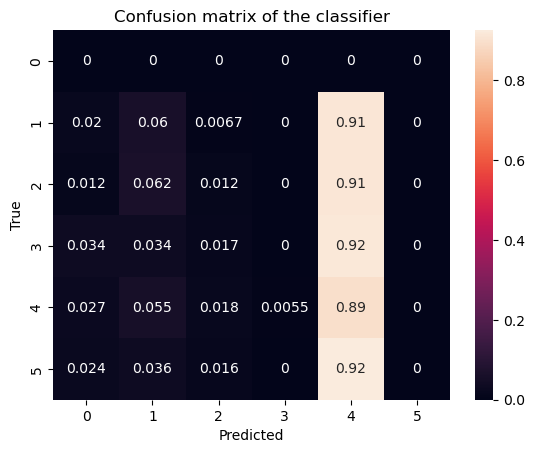

In [3]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import os
os.environ['JAVA_HOME'] = 'F:\javajdk' 

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0)
X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100)
param_grid = ParamGridBuilder().addGrid(
        als.rank, [10, 50]).addGrid(
        als.regParam, [.1]).addGrid(
        als.maxIter, [10]).build()
evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="Score", 
        predictionCol="prediction")
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
cv_fit = cv.fit(df)
rec_sys = cv_fit.bestModel

# rec_sys.save('rec_sys.obj') # so we don't have to re-train it
rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])).toPandas()
X_test_merged = X_test_processed.merge(rec, on=['UserId_fact', 'ProductId_fact'], how='left')
average_score = init_df['Score'].mean()
X_test_merged['prediction'] = X_test_merged['prediction'].fillna(average_score)

print("Kaggle RMSE = ", mean_squared_error(Y_test,X_test_merged['prediction'],  squared=False))
cm = confusion_matrix(Y_test, X_test_merged['prediction'].astype(int), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()